In [1]:
import random
import torch
import gc
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from torch.nn import functional as F
from transformers import logging
logging.set_verbosity_error()

# model_name = 'flax-community/papuGaPT2'
model_name = 'eryk-mazus/polka-1.1b'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
set_seed(42)

In [2]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
torch.cuda.empty_cache()
gc.collect()

171

In [3]:
def generate_examples(digits, n_exampels, operator_string):
    assert operator_string in {"*", "+", "-"}
    res = list()
    counter = n_exampels
    min_number = 10**(digits-1)
    max_number = 10**digits - 1

    while counter > 0:
        num1 = random.randint(min_number, max_number)
        num2 = random.randint(min_number, max_number)
        res.append(f"{num1} {operator_string} {num2} = {eval(f"{num1} {operator_string} {num2}")}")
        counter -= 1
    return '\n'.join(res)

generate_examples(1, 10, "-")

'2 - 1 = 1\n5 - 4 = 1\n4 - 3 = 1\n2 - 9 = -7\n2 - 7 = -5\n1 - 1 = 0\n2 - 4 = -2\n4 - 9 = -5\n1 - 9 = -8\n4 - 9 = -5'

In [4]:
def perform_test(digits, few_shot_examples, operator_string, batch_size=100):
    assert operator_string in {"*", "+", "-"}
    operation = {"*": "mnożenia", "+": "dodawania", "-": "odejmowania"}[operator_string]
    correct = 0
    incorrect = 0

    start_prompt = f"Wykonaj działanie arytmetyczne dopisując wynik po zanku równoiści. Przykładowe {operation} liczb:\n{generate_examples(digits, few_shot_examples, operator_string)}\n\nOblicz to działanie:\n"

    prompts = []
    current_bacth_size = 0

    start = 10**(digits-1) if digits > 1 else 0
    end = 10**digits

    for num1 in range(start, end):
        for num2 in range(start, end):
            prompt = start_prompt + f"{num1} {operator_string} {num2} =" # nie wiem czy dawac spacje na koniec
            prompts.append(prompt)
            current_bacth_size += 1

            if current_bacth_size == batch_size or (num1 == end - 1 and num2 == end - 1):
                inputs = tokenizer(prompts, return_tensors="pt", padding=True)
                inputs = {key: val.to(device) for key, val in inputs.items()}

                outputs = model.generate(**inputs, max_new_tokens=(digits*2)+1)
                results = tokenizer.batch_decode(outputs, skip_special_tokens=True)

                for i, result in enumerate(results):
                    try:
                        result_str = result.strip().split('\n')[-1].replace("=", "==")
                        if eval(result_str): correct += 1
                        else: incorrect += 1
                    except:
                        incorrect += 1
                
                prompts = []
                current_bacth_size = 0
                del inputs, outputs, results
                gc.collect()
                torch.cuda.empty_cache()

    return correct, incorrect

In [36]:
def plot_performance_results(res):
    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    fig.suptitle('Performance Results in Arithmetic Operations', fontsize=16)

    operations = ['addition', 'subtraction', 'multiplication']
    titles = ['Addition', 'Subtraction', 'Multiplication']
    digits = [1, 2]

    for i, operation in enumerate(operations):
        for j, digit in enumerate(digits):
            correct, incorrect = res[operation][digit]
            total = correct + incorrect
            correct_percent = (correct / total) * 100
            incorrect_percent = (incorrect / total) * 100

            bars = axs[i, j].bar(['Correct', 'Incorrect'], [correct, incorrect], color=['green', 'red'])
            axs[i, j].set_title(f'{titles[i]} - {digit}-digit numbers', pad=20)
            axs[i, j].set_ylabel('Number of Results')
            axs[i, j].set_ylim(0, max(correct, incorrect) + 10)

            for bar, percent in zip(bars, [correct_percent, incorrect_percent]):
                height = bar.get_height()
                axs[i, j].text(bar.get_x() + bar.get_width() / 2.0, height, f'{percent:.1f}%', ha='center', va='bottom')

            axs[i, j].grid(True, linestyle='-', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [6]:
res = {"addition": {}, "subtraction": {}, "multiplication": {}}

In [7]:
print(torch.cuda.memory_summary(device=0))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4384 MiB |   4384 MiB |   4384 MiB |      0 B   |
|       from large pool |   4384 MiB |   4384 MiB |   4384 MiB |      0 B   |
|       from small pool |      0 MiB |      0 MiB |      0 MiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |   4384 MiB |   4384 MiB |   4384 MiB |      0 B   |
|       from large pool |   4384 MiB |   4384 MiB |   4384 MiB |

In [8]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True 

In [9]:
for i in range(1, 3):
    res["addition"][i] = perform_test(digits=i, few_shot_examples=10*i, operator_string="+")
    print(f'addition {i} ', res["addition"][i])
    torch.cuda.empty_cache()
    res["subtraction"][i] = perform_test(digits=i, few_shot_examples=10*i, operator_string="-")
    print(f'substraction {i} ', res["subtraction"][i])
    torch.cuda.empty_cache()
    res["multiplication"][i] = perform_test(digits=i, few_shot_examples=10*i, operator_string="*")
    print(f'multiplication {i} ', res["multiplication"][i])
    torch.cuda.empty_cache()

addition 1  (77, 23)
substraction 1  (26, 74)
multiplication 1  (63, 37)
addition 2  (6633, 1467)
substraction 2  (7715, 385)
multiplication 2  (408, 7692)


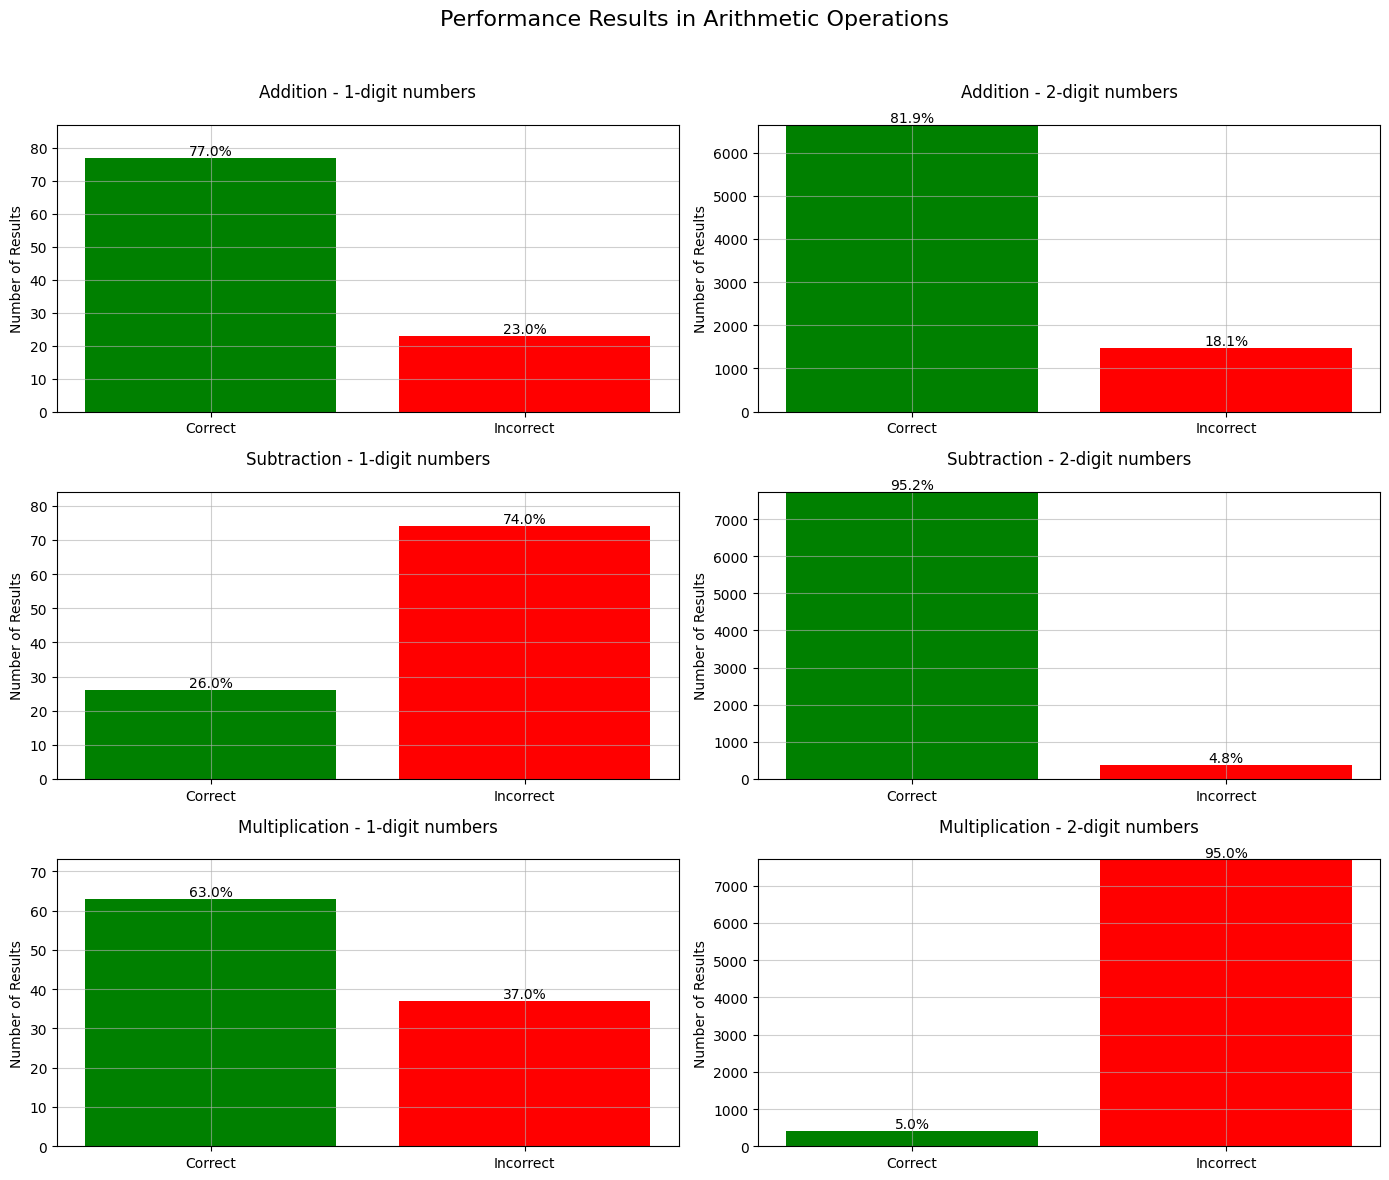

In [37]:
plot_performance_results(res)

## Overall performace 

... for addition, substraction and multiplication for numbers up to two digits

In [ ]:
operation_accuracy = {}
operations = ['addition', 'subtraction', 'multiplication']
all_correst = 0
all_incorrest = 0

for operation in operations:
    total_correct = sum(res[operation][i][0] for i in res[operation])
    total_incorrect = sum(res[operation][i][1] for i in res[operation])
    all_correst += total_correct
    all_incorrest += total_incorrect
    total = total_correct + total_incorrect
    accuracy = (total_correct / total) * 100
    operation_accuracy[operation] = accuracy

operation_accuracy

{'addition': 81.82926829268293,
 'subtraction': 94.40243902439023,
 'multiplication': 5.7439024390243905}

In [44]:
f"Overall accuracy: {(all_correst / (all_correst + all_incorrest)) * 100:.2f}%"

'Overall accuracy: 60.66%'